# Entanglement Classifier Training Trial

## Importing Dependencies

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sympy.physics.quantum import TensorProduct

from components.partial_transpose import partialTranspose
from components.rotation import generateBipartiteRotation
from components.system import System
from components.interaction import InteractionFactory, Interaction
from components.model import Model
from components.interaction_functions import CascadeFunction, EnergyExchangeFunction, DampingFunction
from components.state_generator import generateMixedBatch, generatePureBatch, generateEntangledBatch, generateSeparableBatch, generateGeneralBatch
from components.entanglement import assessEntanglement

[[ 1.+0.j -0.-0.j  0.+0.j  0.-0.j  0.+0.j -0.+0.j -0.-0.j -0.+0.j]
 [-0.+0.j  1.+0.j -0.+0.j  0.-0.j  0.-0.j  0.+0.j  0.+0.j -0.-0.j]
 [ 0.-0.j -0.-0.j  1.+0.j -0.-0.j -0.+0.j  0.+0.j -0.+0.j -0.-0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  1.+0.j -0.-0.j -0.+0.j -0.-0.j -0.-0.j]
 [ 0.+0.j  0.+0.j -0.-0.j -0.+0.j  1.+0.j  0.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j  0.-0.j  0.-0.j -0.-0.j  0.+0.j  1.+0.j -0.-0.j -0.+0.j]
 [-0.+0.j  0.-0.j -0.+0.j -0.+0.j -0.+0.j -0.+0.j  1.+0.j  0.-0.j]
 [-0.-0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j  0.+0.j  1.+0.j]]


## Generating Training Data

In [2]:
samples = 2000
test_size = 0.5

In [3]:
x_separable = generateSeparableBatch(int(samples/2), dim=4)
y_pure = np.ones(int(samples/2))
x_entangled = generateEntangledBatch(int(samples/2), dim=4)
y_mixed = np.zeros(int(samples/2))

In [7]:
generalBatch = generateGeneralBatch(100000, 8)

In [9]:
[state for state in generalBatch if assessEntanglement(state) == 0][0]

array([[ 1.57246982e-01-6.07153217e-18j,  1.36908889e-02+2.54750310e-02j,
        -3.38720660e-03+1.95440429e-02j,  8.38095886e-03-3.89750768e-02j,
         5.83020530e-03-9.31540870e-04j,  3.01268481e-02-4.31659693e-03j,
         4.38101922e-04+2.32644505e-02j,  1.48975387e-02+3.00937649e-02j],
       [ 1.36908889e-02-2.54750310e-02j,  1.10556474e-01-2.60208521e-18j,
        -4.84370487e-04+1.54750694e-02j, -2.83287069e-02+2.95176671e-03j,
        -8.69169818e-05+1.68543084e-02j, -2.20164571e-02-1.94170387e-02j,
         3.21463252e-03-4.86671287e-03j,  1.63395914e-03+4.12585863e-02j],
       [-3.38720660e-03-1.95440429e-02j, -4.84370487e-04-1.54750694e-02j,
         1.19448131e-01-8.67361738e-18j, -1.95754468e-02+5.53546298e-03j,
        -1.12512772e-02+1.61622847e-02j, -1.62985316e-02+1.11034596e-02j,
         3.08838150e-03+3.18327982e-03j,  4.08230023e-03+2.23885225e-03j],
       [ 8.38095886e-03+3.89750768e-02j, -2.83287069e-02-2.95176671e-03j,
        -1.95754468e-02-5.53546298e

In [10]:
x = np.concatenate([x_separable, x_entangled])
y = np.concatenate([y_pure, y_mixed])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, shuffle=True)

## Generate Reservoir Measurements

### Setting up the system

In [ ]:
reservoir_nodes=2
system_nodes=2

In [ ]:
"""
Defining System setup
"""

system_state = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
system_node_list = [0, 1]

if len(system_node_list) != system_nodes:
    raise Exception

system_interactions = {"sys_interaction_0" : Interaction(0, DampingFunction(0, reservoir_nodes+system_nodes, 1)),
                       "sys_interaction_1" : Interaction(1, DampingFunction(1, reservoir_nodes+system_nodes, 1))}

system = System(
    init_quantum_state=system_state, nodes=system_node_list, interactions=system_interactions
)

### Setting up the interface

In [ ]:
"""
Defining Interface setup
"""

interfaceFactory1 = InteractionFactory(CascadeFunction, gamma_1=1, gamma_2=1)
interfaceFactory2 = InteractionFactory(CascadeFunction, gamma_1=0, gamma_2=0)

### Setting up the reservoir

In [ ]:
"""
Defining Reservoir setup
"""

reservoirFactory1 = InteractionFactory(EnergyExchangeFunction, coupling_strength=1)
reservoirFactory2 = InteractionFactory(DampingFunction, damping_strength=1)

### Setting up the model

In [ ]:
model = Model()
model.setSystem(system)
model.setReservoirInteractionFacs(dualFactories=[reservoirFactory1], singleFactories=[reservoirFactory2])
model.setInterfaceInteractionFacs([[interfaceFactory1, interfaceFactory2]])
model.generateReservoir(reservoir_nodes, init_quantum_state=0, interaction_rate=1)
model.generateInterface(interaction_rate=.5)
model.setRunDuration(3.5)
model.setRunResolution(0.02)
model.setSwitchStructureTime(2)

### Running the model

In [ ]:
d_train = []
d_test = []
progress = 0
for state in x_train:
    d_train.append(model.transform(state))
    progress+=1
    print(progress)

for state in x_test:
    d_test.append(model.transform(state))
    progress+=1
    print(progress)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


KeyboardInterrupt: 

## Classical Processing

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [ ]:
mlp = MLPRegressor(max_iter=2000).fit(np.array(d_train), y_train)

In [ ]:
mlp.score(np.array(d_test), y_test)

0.9885206287730071

In [ ]:
y_pred = mlp.predict(np.array(d_test))

In [ ]:
y_true = [np.trace(np.matmul(mat, mat)) for mat in x_test]

In [ ]:
y_true[:10]

[0.5222408004728745,
 0.8764591104611479,
 0.654403165787486,
 0.7907430441115773,
 0.805100477989202,
 0.5269016108277477,
 0.8307063520076372,
 0.621578567730902,
 0.516604024318229,
 0.8913709575893383]

In [ ]:
y_pred[:10]

array([0.52625061, 0.83499354, 0.68568029, 0.78826436, 0.80302464,
       0.53448784, 0.83084883, 0.63368992, 0.51460908, 0.85946665])

In [ ]:
len([np.trace(np.matmul(mat, mat)) for mat in generateMixedBatch(100000) if np.trace(np.matmul(mat, mat)) > 0.99])

7476

C:\Users\mmack\anaconda3\envs\entanglement_classifier\lib\site-packages\numpy\lib\histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\Users\mmack\anaconda3\envs\entanglement_classifier\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(array([ 106.,  175.,  219.,  303.,  303.,  351.,  392.,  418.,  422.,
         466.,  495.,  495.,  533.,  543.,  563.,  595.,  579.,  644.,
         655.,  674.,  688.,  718.,  738.,  690.,  788.,  763.,  756.,
         781.,  790.,  790.,  804.,  818.,  884.,  871.,  879.,  899.,
         879.,  908.,  999.,  964.,  986.,  944., 1018.,  976., 1007.,
        1006., 1047., 1079., 1020., 1003., 1049., 1099., 1032., 1105.,
        1081., 1147., 1123., 1109., 1102., 1138., 1203., 1155., 1156.,
        1135., 1209., 1273., 1220., 1185., 1217., 1255., 1250., 1247.,
        1298., 1233., 1282., 1288., 1240., 1321., 1414., 1368., 1316.,
        1415., 1425., 1319., 1401., 1398., 1355., 1455., 1466., 1425.,
        1432., 1473., 1445., 1469., 1483., 1449., 1483., 1447., 1486.,
        1500.]),
 array([0.50033305+0.j, 0.50532966+0.j, 0.51032627+0.j, 0.51532288+0.j,
        0.52031949+0.j, 0.52531611+0.j, 0.53031272+0.j, 0.53530933+0.j,
        0.54030594+0.j, 0.54530255+0.j, 0.55029917+0.j, 0.

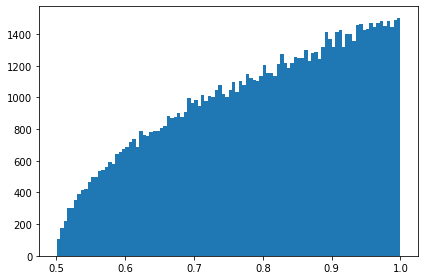

In [ ]:
import matplotlib.pyplot as plt
n_bins = 100

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist([np.trace(np.matmul(mat, mat)) for mat in generateMixedBatch(100000, dim=2)], bins=n_bins)
 

In [ ]:
y_pred = mlp.predict(np.array(d_test))
confusion_matrix(y_test, y_pred)

ValueError: continuous is not supported

In [ ]:
model.reservoir.dualInteractions

{'res_interaction_0_12': <components.interaction.Interaction at 0x1fb7685cee0>,
 'res_interaction_0_13': <components.interaction.Interaction at 0x1fb1b129520>,
 'res_interaction_0_23': <components.interaction.Interaction at 0x1fb75d500d0>}